<a href="https://colab.research.google.com/github/sierrarowley/research_fall2020/blob/master/data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import math

xbound = 10
ybound = 10
point_bound = 1000

def generatedata():
  db = np.empty((xbound, ybound), dtype=object)
  # create random number of points
  for n in range(0, random.randint(1, point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    # at most 10 values per point
    elif len(db[x, y]) < 10:
      db[x, y].append(enc)
  
  return db

generate_dense and generate_sparse are functions that create databases that are specifically dense and sparse. These ensure that some dense and some sparse databases will be used as input to the nn. This also allows there to be a smaller number of points in the database to make the neural net run faster.

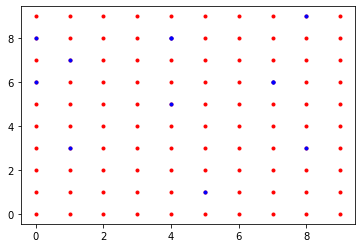

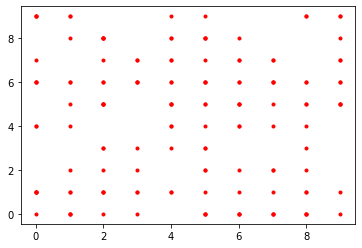

array([[list([-3077298495310921410]),
        list([9084031143345607731, -5912256078741709999, -8232935146622240065, 7213241266404040682]),
        None, None, list([-574872546904999860, 6017362651144548105]),
        None,
        list([2681258561705927423, 6514723244857289300, 4955665986838001803]),
        list([8159403623207580371]), None,
        list([-1161038697580067492, 1018887320360536116, 2662032067349300221])],
       [list([-4859332856438010367, 1615704041565395277, -4662563055105104630]),
        list([-4793850962604189339, -1783700508499759498]),
        list([6066830116301132258]), None, list([7329883428107206769]),
        list([3418708655835743545]),
        list([7466394468692226756, 4745355405979276781]), None,
        list([-1080786464837814938]),
        list([2723270037294478019, -5144879712106413318])],
       [list([-195697715415733206]),
        list([-8721808339976420933, -5928154512239627404, -6068010419509051191]),
        list([-5729766117145158336]),
    

In [11]:
extra_point_bound = 50

def generate_dense():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  xsprinkle = []
  ysprinkle = []
  # create point at each index
  for x in range(0, xbound):
    for y in range(0, ybound):
      # encrypt value of point
      randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
      enc = hash(randstring + str(x) + str(y))
      # store encrypted point in the database
      db[x, y] = [enc]
      xvalues.append(x)
      yvalues.append(y)

  # sprinkle random number of extra points around db
  for n in range(0, random.randint(1, extra_point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)
    xsprinkle.append(x)
    ysprinkle.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))
    db[x, y].append(enc)

  plt.plot(xvalues, yvalues, 'r.')
  plt.plot(xsprinkle, ysprinkle, 'b.')
  plt.show()
  return db

sparse_point_bound = 150

def generate_sparse():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  # create random number of points
  for n in range(0, random.randint(1, sparse_point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)
    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  plt.plot(xvalues, yvalues, 'r.')
  plt.show()
  
  return db

generate_dense()
generate_sparse()

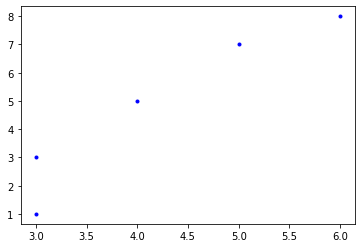

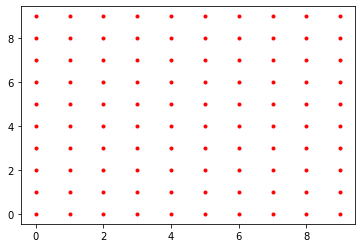

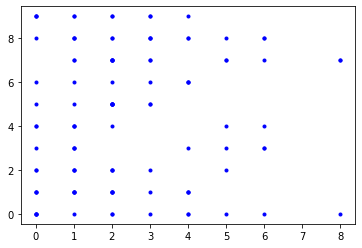

array([[list([-4383352314891907673, 128371211457420646, -8059960222268616740, -3885676773233043435]),
        list([-8395191822805326103, -7625885486353412681, 6949873738860052864]),
        list([-1355439411273526449, 4370258207268746235]),
        list([-1296634713740273045]),
        list([-2115374634801138923, 3180017011449682852]),
        list([-4997137329159333958]), list([-4845759770467474792]), None,
        list([2560580492398372754]),
        list([8266347365796460985, 7961416411563828806, -7955764316402755997])],
       [list([7662165789482237902]),
        list([-5286504081686478834, 2182165436446279638, -2091243889778827103, -9136084090775567150]),
        list([-7986474443274081248, 1061429127407438115, 1419967390898640992]),
        list([-1251142642655519411, 2423267823064928310, -2682562585437413304]),
        list([1331349476473063567, 8877424772168093924, 1245312504166235907]),
        list([3225412810453643122]), list([-4405174359440859898]),
        list([22218060

In [16]:
small_point_bound = 5

def generate_sparse_small():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  # create random number of points
  for n in range(0, random.randint(1, small_point_bound)):
    if n > 2:
      x = random.randint(0, int((xbound-1)/2))
      y = random.randint(0, int((ybound-1)/2))
    else:
      x = random.randint(int((xbound-1)/2), xbound-1)
      y = random.randint(int((ybound-1)/2), ybound-1)
    xvalues.append(x)
    yvalues.append(y)
    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  plt.plot(xvalues, yvalues, 'b.')
  plt.show()
  
  return db


def generate_dense_exact():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []

  # create point at each index
  for x in range(0, xbound):
    for y in range(0, ybound):
      # encrypt value of point
      randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
      enc = hash(randstring + str(x) + str(y))
      # store encrypted point in the database
      db[x, y] = [enc]
      xvalues.append(x)
      yvalues.append(y)

  plt.plot(xvalues, yvalues, 'r.')
  plt.show()

  return db


def generate_sparse_cluster():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  x_range = int((xbound-1)/4)

  for n in range(0, random.randint(50, 70)):
    x = random.randint(0, x_range)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(20, 50)):
    x = random.randint(x_range, x_range*2)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(10, 20)):
    x = random.randint(x_range*2, x_range*3)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(1, 10)):
    x = random.randint(x_range*3, x_range*4)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  plt.plot(xvalues, yvalues, 'b.')
  plt.show()
  
  return db



generate_sparse_small()
generate_dense_exact()
generate_sparse_cluster()

In [4]:
from google.colab import files 


uploaded = files.upload()

Saving Crimes_-_Map.csv to Crimes_-_Map (1).csv


In [6]:
import pandas as pd 
import io 

crimesmap = pd.read_csv(io.BytesIO(uploaded['Crimes_-_Map.csv']))
crimesmap.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,JD163753,02/24/2020 08:15:00 PM,031XX W LEXINGTON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,N,N,1134,24.0,11,NaN,NaN,NaN,NaN,NaN
1,JD212847,04/10/2020 10:56:00 PM,005XX W 103RD ST,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,2232,9.0,08A,1174583.0,1836593.0,41.707001,-87.636288,"(41.707000821, -87.636288063)"
2,JD407638,10/19/2020 09:00:00 AM,009XX W LELAND AVE,0820,THEFT,$500 AND UNDER,APARTMENT,N,N,1914,46.0,06,NaN,NaN,NaN,NaN,NaN
3,JC497784,11/03/2019 11:40:00 AM,032XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,N,N,1924,44.0,06,NaN,NaN,NaN,NaN,NaN
4,JD242916,05/24/2020 09:00:00 PM,011XX S DELANO CT E,0810,THEFT,OVER $500,RESIDENCE - GARAGE,N,N,123,25.0,06,NaN,NaN,NaN,NaN,NaN


In [ ]:
def crimes_data(crimesmap):
  crimesmap = np.array(crimesmap)
  # select x coord and y coord columns from crimes map data set
  crimesmap_xy = crimesmap[:, 12:14]

  # remove all nan rows from data
  row = crimesmap_xy.shape[0]-1
  while row >= 0:
    if math.isnan(crimesmap_xy[row, 0]) or math.isnan(crimesmap_xy[row, 1]) or crimesmap_xy[row, 0] == 0:
      crimesmap_xy = np.delete(crimesmap_xy, row, axis=0)
    row -= 1

  crimesmap_xy = crimesmap_xy[:150, :]

  # get max x and y coordinates to determine size of database
  db_maxsize = np.argmax(crimesmap_xy, axis=0)
  db = np.empty((int(crimesmap_xy[db_maxsize[0],0]), int(crimesmap_xy[db_maxsize[1], 1])), dtype=object)

  # add each x, y coordinate to the database as a hashed value
  for n in range(0, crimesmap_xy.shape[0]):
    x = int(crimesmap_xy[n, 0])
    y = int(crimesmap_xy[n, 1])
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))
    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  return db

crimes_data(crimesmap)

The database is classified as either sparse (0) or dense (1). produce_leakage() performs every possible query of the database and saves the results from those queries in a list. The list is returned at the end.

In [4]:
max_query_length = 100
max_rect_l = 5
max_rect_w = 5

def produce_leakage(db):
  leakage = []
  empty_query_rows = [] # keep track of empty rows(queries) for padding purposes
  query_num = 0 # keep track of row(query) number for empty_query_rows
  dense_flag = 1
  querylen = 0
  # all possible size rectangle queries.
  for l in range(1, max_rect_l+1):
    for w in range(1, max_rect_w+1):
      # all possible starting points of the rectangle query
      for x in range(0, xbound):
        # dont perform query if it is out of bounds
        if x+l > xbound:
          break
        for y in range(0, ybound):
          if y+w > ybound:
            break

          # if any point in database is None, then it is not dense
          if db[x, y] == None:
            dense_flag = 0

          curr_query = []
          # loop through current query in the database
          for i in range(x, x+l):
            for j in range(y, y+w):
              # dont add anymore points if query is at max length (to make nn faster)
              # if len(curr_query) >= max_query_length:
              #   break
              # if a point(s) exists at this location in database, add it to the current query
              if db[i, j] != None:
                curr_query.extend(db[i, j])

          # if query is empty, then add [-1] to represent empty         
          if not curr_query:
            leakage.append([-1])
            # keep track of empty queries for padding later
            empty_query_rows.append(query_num)
          # else add query leakage to entire leakage list
          else :
            leakage.append(curr_query)

          # keep track of longest query length for creating input array
          if len(curr_query) > querylen:
            querylen = len(curr_query)
          query_num += 1

  return (leakage, dense_flag, empty_query_rows, querylen)

create_database() calls generate_dense() or generate_sparse() (depending on the input parameter) and produce_leakage(), which creates the database and the search query leakages from that database. It then takes the returned list of leakages and transforms it into a 2D numpy array with dimensions (number of queries, length of longest query). All queries with a length shorter than the longest are padded with 0's at the end. Each index of the array represents hashed value of a point in a query. create_database() returns the numpy array, which represents one input to the neural net, and the classification of the database.

In [5]:
def create_database(dense):
  if dense:
    leakage, c, empty_rows, querylen = produce_leakage(generate_dense_exact())
  # if not dense then sparse
  else:
    leakage, c, empty_rows, querylen = produce_leakage(generate_sparse())
  
  numqueries = len(leakage)
  
  input = np.empty((numqueries, querylen))
  for x in range(0, numqueries):
    q = np.array(leakage[x])
    # empty rows are padded with -1 to distinguish them
    if x in empty_rows:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, -1))
    # all other queries are padded with 0 to be same shape
    else:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, 0))

  # shuffle leakage to make order and location of queries less obvious
  np.random.shuffle(input)
  
  return (input, c)

create_nn_data() creates a specified number of databases that will be used in the training and testing sets for the neural net. It pads each input array (from create_database) so they are all of the same size. It returns an array of inputs of size (number of inputs, number of queries, number of items in query) and an array of the labels.

In [6]:
def create_nn_data(num_inputs):
  num_dense = int(num_inputs*0.4)
  data = [] # list to store each database
  labels = np.zeros((num_inputs))
  numqueries = 0
  querylen = 0

  # select random indices to be made into dense databases
  indices = np.arange((num_inputs))
  np.random.shuffle(indices)
  dense_indices = indices[:num_dense]

  # create all databases for input
  for n in range(0, num_inputs):
    # dense_indices contains random values of n to be made dense databases
    if n in dense_indices:
      database, label = create_database(1)
      data.append(database)
      labels[n] = label
    # all others are sparse
    else:
      database, label = create_database(0)
      data.append(database)
      labels[n] = label

    # find largest shape to later pad all databases to be same size
    if database.shape[0] > numqueries:
      numqueries = database.shape[0]
    if database.shape[1] > querylen:
      querylen = database.shape[1]

  inputs = np.empty((num_inputs, numqueries, querylen))

  # pad each database
  for i in range(0, len(data)):
    d = data[i]
    d = np.pad(d, ((0, 0), (0, max(querylen - d.shape[1], 0))), 'constant', constant_values=(0, 0))
    inputs[i] = d

  return inputs, labels

Time to make the neural net! I will be using tensorflow with keras

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
# preprocess data
n = 1500
inputs, labels = create_nn_data(n)

train_inputs = inputs[0:int(n*.8), :, :, None]
train_labels = labels[0:int(n*.8)]
test_inputs = inputs[int(n*.8):n, :, :, None]
test_labels = labels[int(n*.8):n]

print("train inputs: ", train_inputs.shape, "train labels: ", train_labels.shape)
print("test inputs: ", test_inputs.shape, "test labels: ", test_labels.shape)

# create model
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(96, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(96, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_inputs, train_labels, epochs=7)

test_loss, test_acc = model.evaluate(test_inputs,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

train inputs:  (1200, 1600, 55, 1) train labels:  (1200,)
test inputs:  (300, 1600, 55, 1) test labels:  (300,)
Epoch 1/7
38/38 [==============================] - 73s 2s/step - loss: 3752062223384576.0000 - accuracy: 0.6158
Epoch 2/7
38/38 [==============================] - 73s 2s/step - loss: 20225925840896.0000 - accuracy: 0.8542
Epoch 3/7
38/38 [==============================] - 73s 2s/step - loss: 5885804412928.0000 - accuracy: 0.9042
Epoch 4/7
38/38 [==============================] - 73s 2s/step - loss: 3681298415616.0000 - accuracy: 0.9425
Epoch 5/7
38/38 [==============================] - 73s 2s/step - loss: 2498933817344.0000 - accuracy: 0.9533
Epoch 6/7
38/38 [==============================] - 73s 2s/step - loss: 1580926238720.0000 - accuracy: 0.9642
Epoch 7/7
38/38 [==============================] - 73s 2s/step - loss: 1469347528704.0000 - accuracy: 0.9717
10/10 - 5s - loss: 10223919038464.0000 - accuracy: 0.8900

Test accuracy: 0.8899999856948853


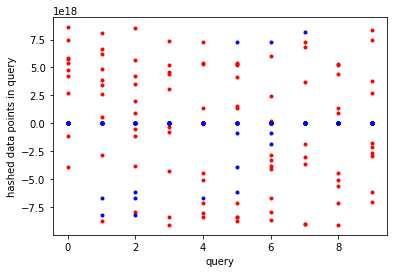

In [ ]:
data, labels = create_nn_data(10)
def plot_data():
  #for i in range(0, data.shape[0]):
  plt.plot(data[0, 0:10, 0:10], 'r.')
  plt.plot(data[1, 0:10, 0:10], 'b.')
  plt.xlabel('query')
  plt.ylabel('hashed data points in query')
  plt.show()

plot_data()